In [2]:
import traci
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import time

In [4]:
SUMO_BINARY = "sumo"
SUMO_CFG_FILE = r"C:\Users\moham\OneDrive\Desktop\2025-05-18-02-24-02\osm.sumocfg"
TRIAL_NAME = "Baseline"
RESULT_DIR = os.path.join(
    r"C:\Users\moham\OneDrive\Desktop\SUMO-RL Results", TRIAL_NAME
)
os.makedirs(RESULT_DIR, exist_ok=True)
WAITING_SPEED_THRESHOLD = 0.1
WARMUP_STEPS=500

# BaseLine

In [3]:
def collect_metrics():
    vehicle_ids = traci.vehicle.getIDList()
    if not vehicle_ids:
        return 0.0, 0, 0.0
    speeds = [traci.vehicle.getSpeed(v) for v in vehicle_ids]
    avg_speed = float(np.mean(speeds))
    volume = len(vehicle_ids)
    total_waiting = sum(
        traci.vehicle.getWaitingTime(v)
        for v in vehicle_ids
        if traci.vehicle.getSpeed(v) < 0.1
    )
    return avg_speed, volume, total_waiting


def run_baseline():
    if traci.isLoaded():
        traci.close()
        time.sleep(1)
    traci.start([SUMO_BINARY, "-c", SUMO_CFG_FILE, "--start", "--quit-on-end"])

    avg_speeds, volumes, waits = [], [], []

    while traci.simulation.getMinExpectedNumber() > 0:  
        sim_time = traci.simulation.getTime()  # SUMO simulation time in seconds
        if sim_time % 250 == 0:
            print(f"Simulation Time: {sim_time} seconds")
        traci.simulationStep()
        s, v, w = collect_metrics()
        avg_speeds.append(s)
        volumes.append(v)
        waits.append(w)
    traci.close()
    return avg_speeds, volumes, waits


def plot_and_save(data, title):
    plt.figure(figsize=(10, 4))
    plt.plot(data, label="Baseline")
    plt.title(title)
    plt.xlabel("Step")
    plt.ylabel(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    filename = title.replace(' ', '_') + '.png'
    path = os.path.join(RESULT_DIR, filename)
    plt.savefig(path)
    plt.close()


def save_metrics_to_txt(data, filename):
    path = os.path.join(RESULT_DIR, filename)
    np.savetxt(path, data, fmt='%.4f')


print("Running baseline simulation...")
Baseline_speeds, Baseline_vols, Baseline_waits = run_baseline()

plot_and_save(Baseline_speeds, 'Average Baseline Speed')
plot_and_save(Baseline_vols, 'Traffic Baseline Volume')
plot_and_save(Baseline_waits, 'Total Baseline Waiting Time')

save_metrics_to_txt(Baseline_speeds, 'Baseline_speeds.txt')
save_metrics_to_txt(Baseline_vols, 'Baseline_volumes.txt')
save_metrics_to_txt(Baseline_waits, 'Baseline_waiting_times.txt')

print(f"Baseline plots and data saved in {RESULT_DIR}")


Running baseline simulation...
Simulation Time: 0.0 seconds
Simulation Time: 250.0 seconds
Simulation Time: 500.0 seconds
Simulation Time: 750.0 seconds
Simulation Time: 1000.0 seconds
Simulation Time: 1250.0 seconds
Simulation Time: 1500.0 seconds
Simulation Time: 1750.0 seconds
Simulation Time: 2000.0 seconds
Simulation Time: 2250.0 seconds
Simulation Time: 2500.0 seconds
Simulation Time: 2750.0 seconds
Simulation Time: 3000.0 seconds
Simulation Time: 3250.0 seconds
Simulation Time: 3500.0 seconds
Simulation Time: 3750.0 seconds
Simulation Time: 4000.0 seconds
Baseline plots and data saved in C:\Users\moham\OneDrive\Desktop\SUMO-RL Results\Baseline


# SARSA

In [ ]:
def collect_metrics():
    vehicle_ids = traci.vehicle.getIDList()
    if len(vehicle_ids) == 0:
        return 0, 0, 0

    speeds = [traci.vehicle.getSpeed(vid) for vid in vehicle_ids]
    avg_speed = np.mean(speeds)
    volume = len(vehicle_ids)

    total_waiting = 0
    for vid in vehicle_ids:
        speed = traci.vehicle.getSpeed(vid)
        if speed < WAITING_SPEED_THRESHOLD:
            total_waiting += traci.vehicle.getWaitingTime(vid)
    return avg_speed, volume, total_waiting



def run_SARSA_simulation(ALPHA,GAMMA,EPSILON,LAMBDA):


    def count_waiting_vehicles(lanes):
        return sum(
            1 for lane in lanes
            for v in traci.lane.getLastStepVehicleIDs(lane)
            if traci.vehicle.getSpeed(v) < WAITING_SPEED_THRESHOLD
        )

    def epsilon_greedy(Q, state, n_actions):
        if random.random() < EPSILON:
            return random.randint(0, n_actions - 1)
        return np.argmax(Q[state])

    def get_state(tls_id):
        lanes = traci.trafficlight.getControlledLanes(tls_id)
        return min(count_waiting_vehicles(lanes), 20)

    if traci.isLoaded():
        traci.close()
    traci.start([SUMO_BINARY, "-c", SUMO_CFG_FILE, "--start", "--quit-on-end"])

    tls_ids = traci.trafficlight.getIDList()
    Q_tables = {}
    E_tables = {}
    n_states = 21
    for tls_id in tls_ids:
        n_actions = len(traci.trafficlight.getAllProgramLogics(tls_id)[0].phases)
        Q_tables[tls_id] = np.zeros((n_states, n_actions))
        E_tables[tls_id] = np.zeros((n_states, n_actions))

    avg_speeds, volumes, total_waits = [], [], []
    states = {}
    actions = {}
    for step in range(WARMUP_STEPS):
        traci.simulationStep()

    for tls_id in tls_ids:
        state = get_state(tls_id)
        action = epsilon_greedy(Q_tables[tls_id], state, Q_tables[tls_id].shape[1])
        states[tls_id] = state
        actions[tls_id] = action

    while traci.simulation.getMinExpectedNumber() > 0: 
        traci.simulationStep()

        for tls_id in tls_ids:
            Q = Q_tables[tls_id]
            E = E_tables[tls_id]
            current_state = states[tls_id]
            action = actions[tls_id]

            traci.trafficlight.setPhase(tls_id, action)

            next_state = get_state(tls_id)
            reward = -next_state
            next_action = epsilon_greedy(Q, next_state, Q.shape[1])

            delta = reward + GAMMA * Q[next_state, next_action] - Q[current_state, action]
            E[current_state, action] += 1

            Q += ALPHA * delta * E
            E *= GAMMA * LAMBDA

            states[tls_id] = next_state
            actions[tls_id] = next_action

        avg_speed, volume, total_waiting = collect_metrics()
        avg_speeds.append(avg_speed)
        volumes.append(volume)
        total_waits.append(total_waiting)

    traci.close()
    return avg_speeds, volumes, total_waits

def plot_and_save_comparison(rl_data, baseline_data, title,OUTPUT_DIR,T_No):
    plt.figure(figsize=(10, 4))
    plt.plot(rl_data, label=f"SARSA_{T_No}", color='blue')
    plt.plot(baseline_data, label="Baseline", color='orange')
    plt.title(f"SARSA_{T_No} vs Baseline: {title}")
    plt.xlabel("Step (after warm-up)")
    plt.ylabel(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    save_path = os.path.join(OUTPUT_DIR, f"{title.replace(' ', '_')}_Comparison.png")
    plt.savefig(save_path)
    plt.close()

def save_metrics_to_txt(data, filename,OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    path = os.path.join(OUTPUT_DIR, filename)
    np.savetxt(path, data, fmt='%.4f')

def load_baseline_data():
    speeds = np.loadtxt(os.path.join(RESULT_DIR, 'Baseline_speeds.txt'))
    vols = np.loadtxt(os.path.join(RESULT_DIR, 'Baseline_volumes.txt'))
    waits = np.loadtxt(os.path.join(RESULT_DIR, 'Baseline_waiting_times.txt'))
    return speeds, vols, waits


baseline_speeds, baseline_volumes, baseline_waits = load_baseline_data()
Baseline_speeds = baseline_speeds[WARMUP_STEPS:]
Baseline_vols = baseline_volumes[WARMUP_STEPS:]
Baseline_waits = baseline_waits[WARMUP_STEPS:]

## SARSA_T1_A(0.4)_G(0.9)_E(0.4)_L(0.8)

In [6]:
TRIAL_NAME = "SARSA_T1_A(0.4)_G(0.9)_E(0.4)_L(0.8)"
OUTPUT_DIR = os.path.join(r"C:\Users\moham\OneDrive\Desktop\SUMO-RL Results", TRIAL_NAME)
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Running SARSA_T1 simulation...")
SARSA_T1_speeds, SARSA_T1_volumes, SARSA_T1_waits = run_SARSA_simulation(0.4, 0.9, 0.4, 0.8)

save_metrics_to_txt(SARSA_T1_speeds, 'SARSA_speeds.txt',OUTPUT_DIR)
save_metrics_to_txt(SARSA_T1_volumes, 'SARSA_volumes.txt',OUTPUT_DIR)
save_metrics_to_txt(SARSA_T1_waits, 'SARSA_waiting_times.txt',OUTPUT_DIR)

plot_and_save_comparison(SARSA_T1_speeds, Baseline_speeds, 'Average Speed',OUTPUT_DIR,"T1")
plot_and_save_comparison(SARSA_T1_volumes, Baseline_vols, 'Traffic Volume',OUTPUT_DIR,"T1")
plot_and_save_comparison(SARSA_T1_waits, Baseline_waits, 'Total Waiting Time',OUTPUT_DIR,"T1")


Running SARSA_T1 simulation...


## SARSA_T2_A(0.2)_G(0.9)_E(0.4)_L(0.8)

In [7]:
TRIAL_NAME = "SARSA_T2_A(0.2)_G(0.9)_E(0.4)_L(0.8)"
OUTPUT_DIR = os.path.join(r"C:\Users\moham\OneDrive\Desktop\SUMO-RL Results", TRIAL_NAME)
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Running SARSA_T2 simulation...")
SARSA_T2_speeds, SARSA_T2_volumes, SARSA_T2_waits = run_SARSA_simulation(0.2, 0.9, 0.4, 0.8)

save_metrics_to_txt(SARSA_T2_speeds, 'SARSA_speeds.txt',OUTPUT_DIR)
save_metrics_to_txt(SARSA_T2_volumes, 'SARSA_volumes.txt',OUTPUT_DIR)
save_metrics_to_txt(SARSA_T2_waits, 'SARSA_waiting_times.txt',OUTPUT_DIR)

plot_and_save_comparison(SARSA_T2_speeds, Baseline_speeds, 'Average Speed',OUTPUT_DIR,"T2")
plot_and_save_comparison(SARSA_T2_volumes, Baseline_vols, 'Traffic Volume',OUTPUT_DIR,"T2")
plot_and_save_comparison(SARSA_T2_waits, Baseline_waits, 'Total Waiting Time',OUTPUT_DIR,"T2")


Running SARSA_T2 simulation...


## SARSA_T3_A(0.4)_G(0.99)_E(0.4)_L(0.8)

In [8]:
TRIAL_NAME = "SARSA_T3_A(0.4)_G(0.99)_E(0.4)_L(0.8)"
OUTPUT_DIR = os.path.join(r"C:\Users\moham\OneDrive\Desktop\SUMO-RL Results", TRIAL_NAME)
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Running SARSA_T3 simulation...")
SARSA_T3_speeds, SARSA_T3_volumes, SARSA_T3_waits = run_SARSA_simulation(0.4, 0.99, 0.4, 0.8)

save_metrics_to_txt(SARSA_T3_speeds, 'SARSA_speeds.txt',OUTPUT_DIR)
save_metrics_to_txt(SARSA_T3_volumes, 'SARSA_volumes.txt',OUTPUT_DIR)
save_metrics_to_txt(SARSA_T3_waits, 'SARSA_waiting_times.txt',OUTPUT_DIR)

plot_and_save_comparison(SARSA_T3_speeds, Baseline_speeds, 'Average Speed',OUTPUT_DIR,"T3")
plot_and_save_comparison(SARSA_T3_volumes, Baseline_vols, 'Traffic Volume',OUTPUT_DIR,"T3")
plot_and_save_comparison(SARSA_T3_waits, Baseline_waits, 'Total Waiting Time',OUTPUT_DIR,"T3")


Running SARSA_T3 simulation...


## SARSA_T4_A(0.4)_G(0.9)_E(0.2)_L(0.8)

In [9]:
TRIAL_NAME = "SARSA_T4_A(0.4)_G(0.9)_E(0.2)_L(0.8)"
OUTPUT_DIR = os.path.join(r"C:\Users\moham\OneDrive\Desktop\SUMO-RL Results", TRIAL_NAME)
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Running SARSA_T4 simulation...")
SARSA_T4_speeds, SARSA_T4_volumes, SARSA_T4_waits = run_SARSA_simulation(0.4, 0.9, 0.2, 0.8)

save_metrics_to_txt(SARSA_T4_speeds, 'SARSA_speeds.txt',OUTPUT_DIR)
save_metrics_to_txt(SARSA_T4_volumes, 'SARSA_volumes.txt',OUTPUT_DIR)
save_metrics_to_txt(SARSA_T4_waits, 'SARSA_waiting_times.txt',OUTPUT_DIR)

plot_and_save_comparison(SARSA_T4_speeds, Baseline_speeds, 'Average Speed',OUTPUT_DIR,"T4")
plot_and_save_comparison(SARSA_T4_volumes, Baseline_vols, 'Traffic Volume',OUTPUT_DIR,"T4")
plot_and_save_comparison(SARSA_T4_waits, Baseline_waits, 'Total Waiting Time',OUTPUT_DIR,"T4")


Running SARSA_T4 simulation...


## SARSA_T5_A(0.4)_G(0.9)_E(0.4)_L(0.4)"

In [10]:
TRIAL_NAME = "SARSA_T5_A(0.4)_G(0.9)_E(0.4)_L(0.4)"
OUTPUT_DIR = os.path.join(r"C:\Users\moham\OneDrive\Desktop\SUMO-RL Results", TRIAL_NAME)
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Running SARSA_T5 simulation...")
SARSA_T5_speeds, SARSA_T5_volumes, SARSA_T5_waits = run_SARSA_simulation(0.4, 0.9, 0.4, 0.4)

save_metrics_to_txt(SARSA_T5_speeds, 'SARSA_speeds.txt',OUTPUT_DIR)
save_metrics_to_txt(SARSA_T5_volumes, 'SARSA_volumes.txt',OUTPUT_DIR)
save_metrics_to_txt(SARSA_T5_waits, 'SARSA_waiting_times.txt',OUTPUT_DIR)

plot_and_save_comparison(SARSA_T5_speeds, Baseline_speeds, 'Average Speed',OUTPUT_DIR,"T1")
plot_and_save_comparison(SARSA_T5_volumes, Baseline_vols, 'Traffic Volume',OUTPUT_DIR,"T1")
plot_and_save_comparison(SARSA_T5_waits, Baseline_waits, 'Total Waiting Time',OUTPUT_DIR,"T1")


Running SARSA_T5 simulation...


# Q-Learning

In [10]:
def collect_metrics():
    vehicle_ids = traci.vehicle.getIDList()
    if len(vehicle_ids) == 0:
        return 0, 0, 0

    speeds = [traci.vehicle.getSpeed(vid) for vid in vehicle_ids]
    avg_speed = np.mean(speeds)
    volume = len(vehicle_ids)

    total_waiting = 0
    for vid in vehicle_ids:
        speed = traci.vehicle.getSpeed(vid)
        if speed < WAITING_SPEED_THRESHOLD:
            total_waiting += traci.vehicle.getWaitingTime(vid)
    return avg_speed, volume, total_waiting


def run_Q_learning_simulation(ALPHA,GAMMA,EPSILON):


    def count_waiting_vehicles(lanes):
        return sum(
            1 for lane in lanes
            for v in traci.lane.getLastStepVehicleIDs(lane)
            if traci.vehicle.getSpeed(v) < WAITING_SPEED_THRESHOLD
        )

    def epsilon_greedy(Q, state, n_actions):
        if random.random() < EPSILON:
            return random.randint(0, n_actions - 1)
        return np.argmax(Q[state])

    def get_state(tls_id):
        lanes = traci.trafficlight.getControlledLanes(tls_id)
        return  min(count_waiting_vehicles(lanes), 20)

    if traci.isLoaded():
        traci.close()
    traci.start([SUMO_BINARY, "-c", SUMO_CFG_FILE, "--start", "--quit-on-end"])

    tls_ids = traci.trafficlight.getIDList()
    Q_tables = {}
    for tls_id in tls_ids:
        n_actions = len(traci.trafficlight.getAllProgramLogics(tls_id)[0].phases)
        Q_tables[tls_id] = np.zeros((21, n_actions))

    avg_speeds, volumes, total_waits = [], [], []

    for step in range(WARMUP_STEPS):
        traci.simulationStep()

    while traci.simulation.getMinExpectedNumber() > 0: 
        traci.simulationStep()

        for tls_id in tls_ids:
            Q = Q_tables[tls_id]
            n_actions = Q.shape[1]
            state = get_state(tls_id)
            action = epsilon_greedy(Q, state, n_actions)
            traci.trafficlight.setPhase(tls_id, action)

            next_state = get_state(tls_id)
            reward = -next_state
            best_next_action = np.argmax(Q[next_state])

            Q[state, action] += ALPHA * (reward + GAMMA * Q[next_state, best_next_action] - Q[state, action])

        avg_speed, volume, total_waiting = collect_metrics()
        avg_speeds.append(avg_speed)
        volumes.append(volume)
        total_waits.append(total_waiting)

    traci.close()
    return avg_speeds, volumes, total_waits


def plot_and_save_comparison(rl_data, baseline_data, title,OUTPUT_DIR,T_No):
    plt.figure(figsize=(10, 4))
    plt.plot(rl_data, label=f"Q-Learning{T_No}", color='blue')
    plt.plot(baseline_data, label="Baseline", color='orange')
    plt.title(f"Q-Learning{T_No} vs Baseline: {title}")
    plt.xlabel("Step (after warm-up)")
    plt.ylabel(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    save_path = os.path.join(OUTPUT_DIR, f"{title.replace(' ', '_')}_Comparison.png")
    plt.savefig(save_path)
    plt.close()

def save_metrics_to_txt(data, filename,OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    path = os.path.join(OUTPUT_DIR, filename)
    np.savetxt(path, data, fmt='%.4f')

def load_baseline_data():
    speeds = np.loadtxt(os.path.join(RESULT_DIR, 'Baseline_speeds.txt'))
    vols = np.loadtxt(os.path.join(RESULT_DIR, 'Baseline_volumes.txt'))
    waits = np.loadtxt(os.path.join(RESULT_DIR, 'Baseline_waiting_times.txt'))
    return speeds, vols, waits

baseline_speeds, baseline_volumes, baseline_waits = load_baseline_data()
Baseline_speeds = baseline_speeds[WARMUP_STEPS:]
Baseline_vols = baseline_volumes[WARMUP_STEPS:]
Baseline_waits = baseline_waits[WARMUP_STEPS:]

## Q_Learning_T1_A(0.4)_G(0.9)_E(0.4)

In [11]:
TRIAL_NAME = "Q_Learning_T1_A(0.4)_G(0.9)_E(0.4)"
OUTPUT_DIR = os.path.join(r"C:\Users\moham\OneDrive\Desktop\SUMO-RL Results", TRIAL_NAME)
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Running Q-Learning simulation...")
Q_T1_speeds, Q_T1_volumes, Q_T1_waits = run_Q_learning_simulation(0.4,0.9,0.4)

save_metrics_to_txt(Q_T1_speeds, 'Q_Learning_speeds.txt',OUTPUT_DIR)
save_metrics_to_txt(Q_T1_volumes, 'Q_Learning_volumes.txt',OUTPUT_DIR)
save_metrics_to_txt(Q_T1_waits, 'Q_Learning_waiting_times.txt',OUTPUT_DIR)

plot_and_save_comparison(Q_T1_speeds, Baseline_speeds, 'Average Speed',OUTPUT_DIR,"T1")
plot_and_save_comparison(Q_T1_volumes, Baseline_vols, 'Traffic Volume',OUTPUT_DIR,"T1")
plot_and_save_comparison(Q_T1_waits, Baseline_waits, 'Total Waiting Time',OUTPUT_DIR,"T1")

Running Q-Learning simulation...


## Q_Learning_T2_A(0.2)_G(0.9)_E(0.4)

In [12]:
TRIAL_NAME = "Q_Learning_T2_A(0.2)_G(0.9)_E(0.4)"
OUTPUT_DIR = os.path.join(r"C:\Users\moham\OneDrive\Desktop\SUMO-RL Results", TRIAL_NAME)
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Running Q-Learning simulation...")
Q_T2_speeds, Q_T2_volumes, Q_T2_waits = run_Q_learning_simulation(0.2,0.9,0.4)

save_metrics_to_txt(Q_T2_speeds, 'Q_Learning_speeds.txt',OUTPUT_DIR)
save_metrics_to_txt(Q_T2_volumes, 'Q_Learning_volumes.txt',OUTPUT_DIR)
save_metrics_to_txt(Q_T2_waits, 'Q_Learning_waiting_times.txt',OUTPUT_DIR)

plot_and_save_comparison(Q_T2_speeds, Baseline_speeds, 'Average Speed',OUTPUT_DIR,"T2")
plot_and_save_comparison(Q_T2_volumes, Baseline_vols, 'Traffic Volume',OUTPUT_DIR,"T2")
plot_and_save_comparison(Q_T2_waits, Baseline_waits, 'Total Waiting Time',OUTPUT_DIR,"T2")

Running Q-Learning simulation...


## Q_Learning_T3_A(0.4)_G(0.99)_E(0.4)

In [13]:
TRIAL_NAME = "Q_Learning_T3_A(0.4)_G(0.99)_E(0.4)"
OUTPUT_DIR = os.path.join(r"C:\Users\moham\OneDrive\Desktop\SUMO-RL Results", TRIAL_NAME)
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Running Q-Learning simulation...")
Q_T3_speeds, Q_T3_volumes, Q_T3_waits = run_Q_learning_simulation(0.4,0.99,0.4)

save_metrics_to_txt(Q_T3_speeds, 'Q_Learning_speeds.txt',OUTPUT_DIR)
save_metrics_to_txt(Q_T3_volumes, 'Q_Learning_volumes.txt',OUTPUT_DIR)
save_metrics_to_txt(Q_T3_waits, 'Q_Learning_waiting_times.txt',OUTPUT_DIR)

plot_and_save_comparison(Q_T3_speeds, Baseline_speeds, 'Average Speed',OUTPUT_DIR,"T3")
plot_and_save_comparison(Q_T3_volumes, Baseline_vols, 'Traffic Volume',OUTPUT_DIR,"T3")
plot_and_save_comparison(Q_T3_waits, Baseline_waits, 'Total Waiting Time',OUTPUT_DIR,"T3")

Running Q-Learning simulation...


## Q_Learning_T4_A(0.4)_G(0.9)_E(0.2)

In [14]:
TRIAL_NAME = "Q_Learning_T4_A(0.4)_G(0.9)_E(0.2)"
OUTPUT_DIR = os.path.join(r"C:\Users\moham\OneDrive\Desktop\SUMO-RL Results", TRIAL_NAME)
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Running Q-Learning simulation...")
Q_T4_speeds, Q_T4_volumes, Q_T4_waits = run_Q_learning_simulation(0.4,0.9,0.2)

save_metrics_to_txt(Q_T4_speeds, 'Q_Learning_speeds.txt',OUTPUT_DIR)
save_metrics_to_txt(Q_T4_volumes, 'Q_Learning_volumes.txt',OUTPUT_DIR)
save_metrics_to_txt(Q_T4_waits, 'Q_Learning_waiting_times.txt',OUTPUT_DIR)

plot_and_save_comparison(Q_T4_speeds, Baseline_speeds, 'Average Speed',OUTPUT_DIR,"T4")
plot_and_save_comparison(Q_T4_volumes, Baseline_vols, 'Traffic Volume',OUTPUT_DIR,"T4")
plot_and_save_comparison(Q_T4_waits, Baseline_waits, 'Total Waiting Time',OUTPUT_DIR,"T4")

Running Q-Learning simulation...


# Best Models

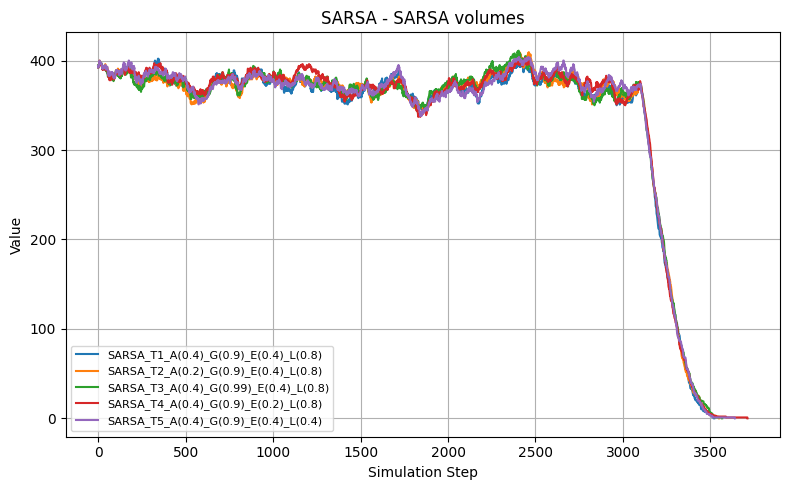

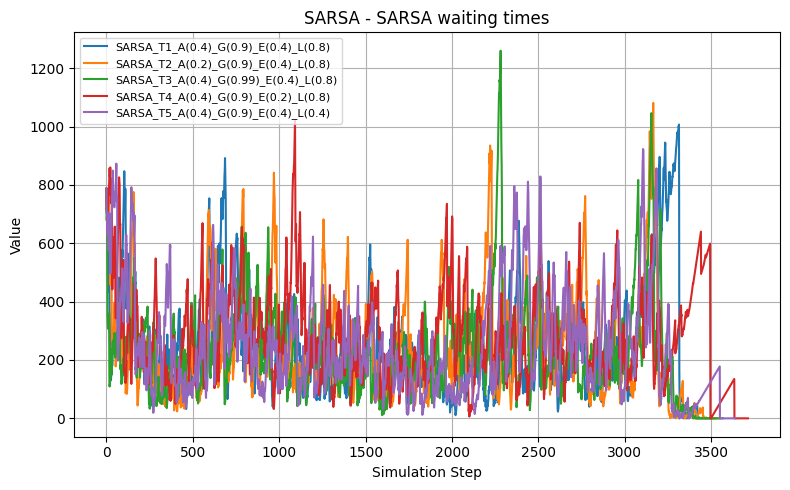

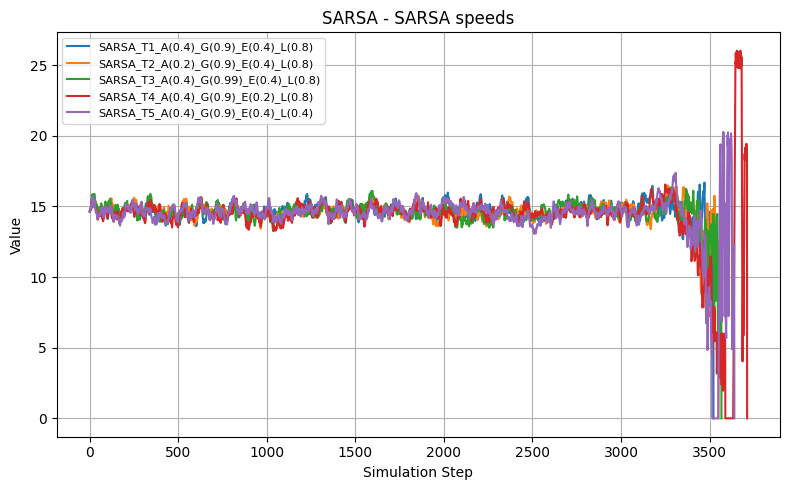

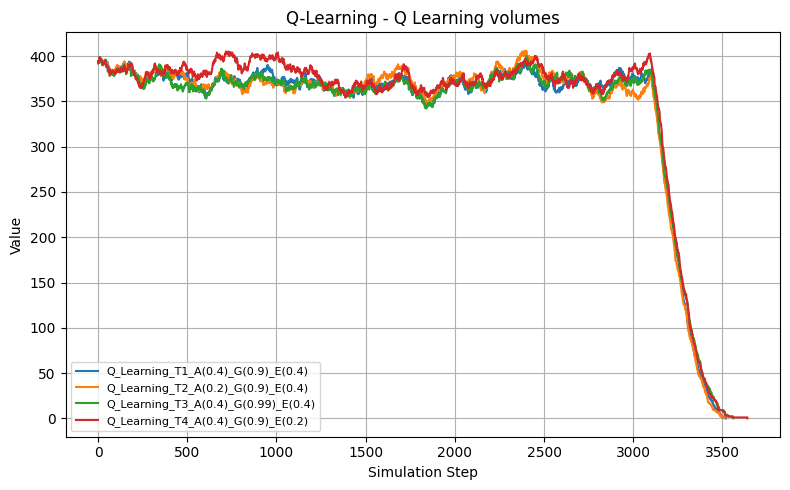

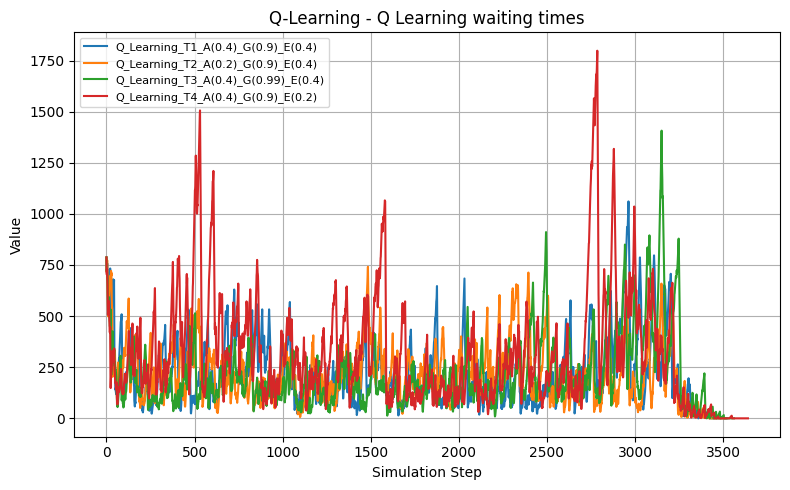

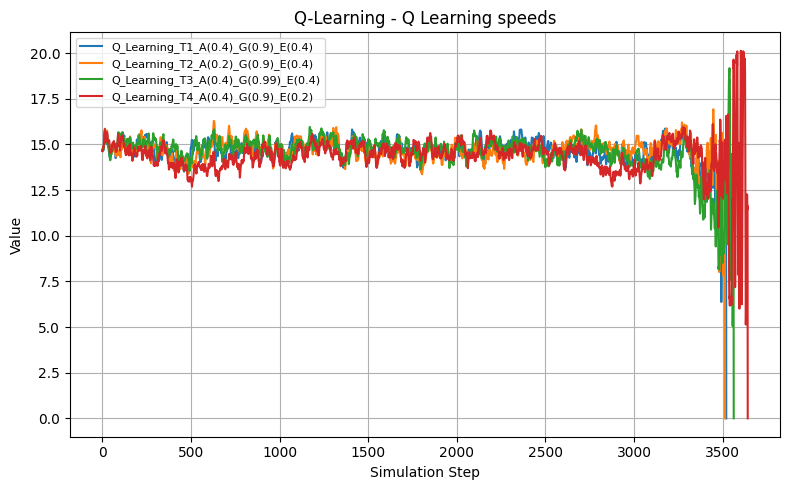


Best Trials:

SARSA volumes:
SARSA Best: SARSA_T4_A(0.4)_G(0.9)_E(0.2)_L(0.8) (Mean=329.54)

SARSA waiting times:
SARSA Best: SARSA_T3_A(0.4)_G(0.99)_E(0.4)_L(0.8) (Mean=223.77)

SARSA speeds:
SARSA Best: SARSA_T1_A(0.4)_G(0.9)_E(0.4)_L(0.8) (Mean=14.68)

Q Learning volumes:
Q-Learning Best: Q_Learning_T4_A(0.4)_G(0.9)_E(0.2) (Mean=339.78)

Q Learning waiting times:
Q-Learning Best: Q_Learning_T3_A(0.4)_G(0.99)_E(0.4) (Mean=207.17)

Q Learning speeds:
Q-Learning Best: Q_Learning_T2_A(0.2)_G(0.9)_E(0.4) (Mean=14.67)



In [15]:
base_path = r'C:\Users\moham\OneDrive\Desktop\SUMO-RL Results'

sarsa_trials = [
    'SARSA_T1_A(0.4)_G(0.9)_E(0.4)_L(0.8)',
    'SARSA_T2_A(0.2)_G(0.9)_E(0.4)_L(0.8)',
    'SARSA_T3_A(0.4)_G(0.99)_E(0.4)_L(0.8)',
    'SARSA_T4_A(0.4)_G(0.9)_E(0.2)_L(0.8)',
    'SARSA_T5_A(0.4)_G(0.9)_E(0.4)_L(0.4)'
]

qlearning_trials = [
    'Q_Learning_T1_A(0.4)_G(0.9)_E(0.4)',
    'Q_Learning_T2_A(0.2)_G(0.9)_E(0.4)',
    'Q_Learning_T3_A(0.4)_G(0.99)_E(0.4)',
    'Q_Learning_T4_A(0.4)_G(0.9)_E(0.2)'
]

SARSA_files=['SARSA_volumes.txt','SARSA_waiting_times.txt','SARSA_speeds.txt']
Q_files = ['Q_Learning_volumes.txt', 'Q_Learning_waiting_times.txt', 'Q_Learning_speeds.txt']

def load_trial_data(files,trial_path):
    data = {}
    for file in files:
        file_path = os.path.join(trial_path, file)
        values = np.loadtxt(file_path)
        data[file] = values
    return data

def plot_metric(files,trials, model_name, metric_file):
    plt.figure(figsize=(8,5))
    for trial in trials:
        trial_path = os.path.join(base_path, trial)
        data = load_trial_data(files,trial_path)  
        plt.plot(data[metric_file], label=trial)
    plt.title(f'{model_name} - {metric_file.replace("_", " ").replace(".txt", "")}')
    plt.xlabel('Simulation Step')
    plt.ylabel('Value')
    plt.legend(fontsize=8)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Plotting
for metric in SARSA_files:
    plot_metric(SARSA_files,sarsa_trials, 'SARSA', metric)
for metric in Q_files:  
    plot_metric(Q_files,qlearning_trials, 'Q-Learning', metric)

# Finding best trials
print("\nBest Trials:\n")
def get_best_trial(trials, files, metric_file, higher_is_better=True):
    best_value = None
    best_trial = None
    for trial in trials:
        trial_path = os.path.join(base_path, trial)
        data = load_trial_data(files, trial_path)
        metric_mean = np.mean(data[metric_file])
        if best_value is None or (higher_is_better and metric_mean > best_value) or (not higher_is_better and metric_mean < best_value):
            best_value = metric_mean
            best_trial = trial
    return best_trial, best_value

for metric in SARSA_files:
    if 'speeds' in metric.lower():
        is_higher_better = True  
    else:
        is_higher_better = False  

    best_qlearning, val_qlearning = get_best_trial(sarsa_trials, SARSA_files, metric, higher_is_better=is_higher_better)
    print(f"{metric.replace('_', ' ').replace('.txt','')}:")
    print(f"SARSA Best: {best_qlearning} (Mean={val_qlearning:.2f})\n")

for metric in Q_files:
    if 'speeds' in metric.lower():
        is_higher_better = True  
    else:
        is_higher_better = False  

    best_qlearning, val_qlearning = get_best_trial(qlearning_trials, Q_files, metric, higher_is_better=is_higher_better)
    print(f"{metric.replace('_', ' ').replace('.txt','')}:")
    print(f"Q-Learning Best: {best_qlearning} (Mean={val_qlearning:.2f})\n")


In [20]:
import traci

if traci.isLoaded():
    traci.close()

traci.start([SUMO_BINARY, "-c", SUMO_CFG_FILE, "--start", "--quit-on-end"])

tls_ids = traci.trafficlight.getIDList()

print("Traffic Light States at Simulation Start:")

for tls_id in tls_ids:
    traci.simulationStep()
    phase = traci.trafficlight.getPhase(tls_id)  # Integer phase index
    program = traci.trafficlight.getCompleteRedYellowGreenDefinition(tls_id)[0]
    state_string = program.phases[phase].state  # Example: 'GrGr' or 'rGrG'
    print(f"TLS ID: {tls_id} | Current Phase Index: {phase} | State String: {state_string}")

traci.close()


Traffic Light States at Simulation Start:
TLS ID: 6441582236 | Current Phase Index: 0 | State String: G
TLS ID: 6441585127 | Current Phase Index: 0 | State String: G
TLS ID: 6441585128 | Current Phase Index: 0 | State String: G
TLS ID: 6441585129 | Current Phase Index: 0 | State String: G
TLS ID: 6446559074 | Current Phase Index: 0 | State String: G
TLS ID: 6446559076 | Current Phase Index: 0 | State String: G
TLS ID: 6446559082 | Current Phase Index: 0 | State String: GGG
TLS ID: 6446579244 | Current Phase Index: 0 | State String: GGG
TLS ID: 6446661059 | Current Phase Index: 0 | State String: GG
TLS ID: 6452961315 | Current Phase Index: 0 | State String: GG
TLS ID: 6465210460 | Current Phase Index: 1 | State String: y
TLS ID: 7621976423 | Current Phase Index: 1 | State String: y
TLS ID: 7621976432 | Current Phase Index: 1 | State String: y
TLS ID: 7621976438 | Current Phase Index: 1 | State String: y
TLS ID: 7688405350 | Current Phase Index: 1 | State String: y
TLS ID: cluster_121104

C:\Users\moham\AppData\Local\Temp\ipykernel_29796\2994397317.py:15: UserWarning: Call to deprecated function getCompleteRedYellowGreenDefinition, use getAllProgramLogics instead.
  program = traci.trafficlight.getCompleteRedYellowGreenDefinition(tls_id)[0]
